## Other Fun Features

Some other features that are included in the $\texttt{stella}$ package include finding rotation periods and fitting flares with a simple analytic model to extract parameters such as the equivalent duration. Here, we will go through each of these additional modules.

In [1]:
import os, sys

import stella
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20

First thing's first: we need a light curve! We're going to use the same one that has been used in the previous demonstrations.

/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/benpope/.lightkurve/cache. Please move all the files in the legacy directory /Users/benpope/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(
/var/folders/vx/lm_q_1ld7c13_fbqfscs9n4w0000gq/T/ipykernel_44312/692024527.py:2: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lc = search_lightcurvefile(target='tic62124646', mission='TESS')
/Users/benpope/opt/anaconda3/envs/stella/lib/python3.12/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 14 files available to download. Only the first file has been dow

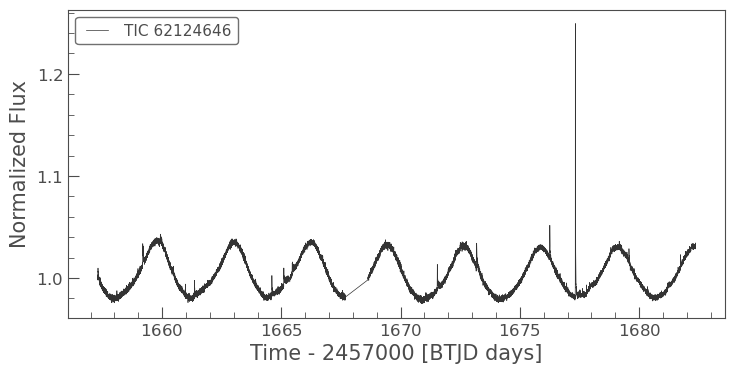

In [2]:
from lightkurve.search import search_lightcurvefile
lc = search_lightcurvefile(target='tic62124646', mission='TESS')
lc = lc.download().PDCSAP_FLUX.normalize()
lc.plot()
lc = lc.remove_nans()

### 1.1 Measuring Rotation Periods

To measure the rotation period of a light curve, you need the following information: a target ID (can be anything you want), a time array, a flux array, and a flux error array. These can all be retrieved from the $\texttt{lightkurve}$ object. Then, you initialize the class $\texttt{stella.MeasureProt}$.

In [16]:
mProt = stella.MeasureProt([lc.targetid], [lc.time], [lc.flux], [lc.flux_err])

The rotation measurement tool used in this class is a Lomb-Scargle Periodogram. You have the option the set the minimum frequency (minf=1/12.5) and maximum frequency (maxf=1/0.1) that the periodogram searches over. You can also set the samples per peak (spp=50). The default values are noted in parentheses.

In [17]:
mProt.run_LS()

Finding most likely periods: 100%|██████████| 1/1 [00:00<00:00, 65.34it/s]


Calling this will create an $\texttt{astropy.table.Table}$ attribute with some metrics about the rotation period measured in that light curve. The columns in this table include:
- Target_ID: the ID for that light curve.
- period_days: the period as measured in the first orbit.
- secondary_period_days: the period as measured in the second orbit.
- gauss_width: the width of a best-fit Gaussian to the most likely period.
- max_power: the power of the periodogram at the most likely period.
- orbit_flag: a combined flag per orbit (0 = reliable measurement).
- oflag1: period flag for the first orbit (0 = reliable measurement).
- oflag2: period flag for the first orbit (0 = reliable measurement).
- Flags: Defines a flag based on all observations of the given target. This mainly applies to stars observed in multiple sectors, otherwise it is the same value as the orbit_flag (0 = reliable measurement).
- avg_period_days: the average most likely period for that target. This is averaged over multiple sectors when available.
    
Note that by fitting to each orbit, we are limiting the period search space to relatively short rotation periods.

In [5]:
mProt.LS_results

Target_ID,period_days,secondary_period_days,gauss_width,max_power,secondary_max_power,orbit_flag,oflag1,oflag2,Flags,avg_period_days
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
62124646,3.2260677295482445,3.2305312439047706,0.3718039134339883,0.9558196108899171,0.17242768646164067,0.0,0.0,0.0,0,3.2260677295482445


For this star, we find a period of 3.23 days. We can fold over this period in $\texttt{lightkurve}$ to see if this period is found in the light curve:

In [6]:
lc.fold(mProt.LS_results['avg_period_days'].data[0]).plot()

<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

That looks nice! (And so do those flares!!)

### 1.2 Fitting Flares

In $\texttt{stella}$, we use a very basic model flare fit of a sharp rise and an exponential decay. This can be done through a class included in the code. The first thing that needs to be done is get predictions for where the flares occur. 

In [18]:
models = stella.models.models
MODEL = models[0]

In [19]:
lc.time

<Time object: scale='tdb' format='btjd' value=[1657.30072021 1657.30210913 1657.30349805 ... 1682.35916695 1682.36055582
 1682.36194469]>

In [22]:
cnn = stella.ConvNN(output_dir='.')
cnn.predict(modelname=MODEL,
            times=lc.time.value,
            fluxes=lc.flux.value,
            errs=lc.flux_err.value)

533/533 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step


In [ ]:
Again, now we have a light curve with predictions from just one of the $\texttt{stella}$ models.

In [10]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0], c=cnn.predictions[0], vmin=0, vmax=1)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

Now we can initiate our flare fitting class, `stella.FitFlares`, and start fitting those flares!

In [11]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn.predictions[0]])

The flares are identified given a certain probability threshold (here, I use a threshold of 0.5, which is what was used in [Feinstein et al. (2020)](https://arxiv.org/abs/2005.07710)). For the cleanest sample of flares, one could explore a higher probability threshold.

Several parameters about the flare are returned in an astropy Table:
- tpeak: the peak time of the flare
- amp: the amplitude of the flare
- dur_min: the duration of the flare, given in minutes
- rise: how quickly the flare goes off (this is very fast and generally the same across all flares)
- fall: the exponential decay
- prob: the probability at the tpeak time

In [12]:
ff.identify_flare_peaks(threshold=0.5)

ff.flare_table

Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
62124646.0,1658.7535278443768,1.0052128801543887,2.1141784490940214,0.0001,0.004022670867278447,0.9841311573982239
62124646.0,1659.1882586333725,1.0154060507584892,6.621588369067813,0.0001,0.004297409883759263,1.0
62124646.0,1659.9257727535307,1.0048429054281693,4.8303669733040255,0.0001,0.01,0.7176441550254822
62124646.0,1660.4716161932422,1.0059462438595412,0.9537076543861422,0.0001,0.0010007312570839155,0.5826319456100464
62124646.0,1661.3591319859026,1.014161251820288,7.005308366193909,0.0001,0.005010685088768947,0.9999992847442627
62124646.0,1661.7896949141884,1.0036819946264086,2.7828348653460218,0.0001,0.01,0.6347841620445251
62124646.0,1662.8813794280497,1.0030408962307105,2.060987492077857,0.0001,0.006332641683045826,0.525276780128479
62124646.0,1664.602238470795,1.0173713029342288,14.230155859933062,0.0001,0.00867600146048688,1.0
62124646.0,1664.602238470795,1.0173713029342288,14.230155859933062,0.0001,0.00867600146048688,1.0


Cool! We can mark all of our flares as well, just to see them better by-eye:

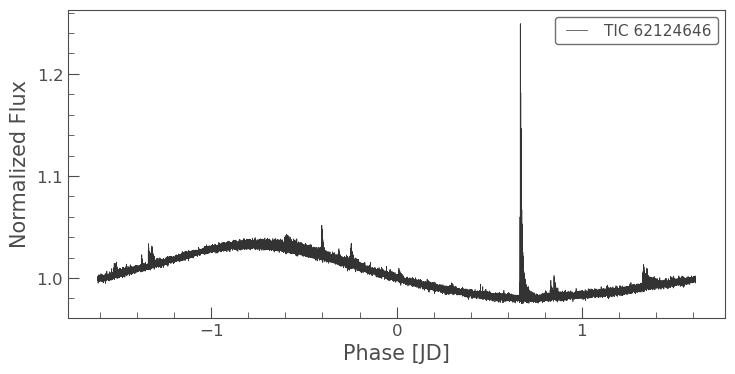

<Figure size 1400x400 with 0 Axes>

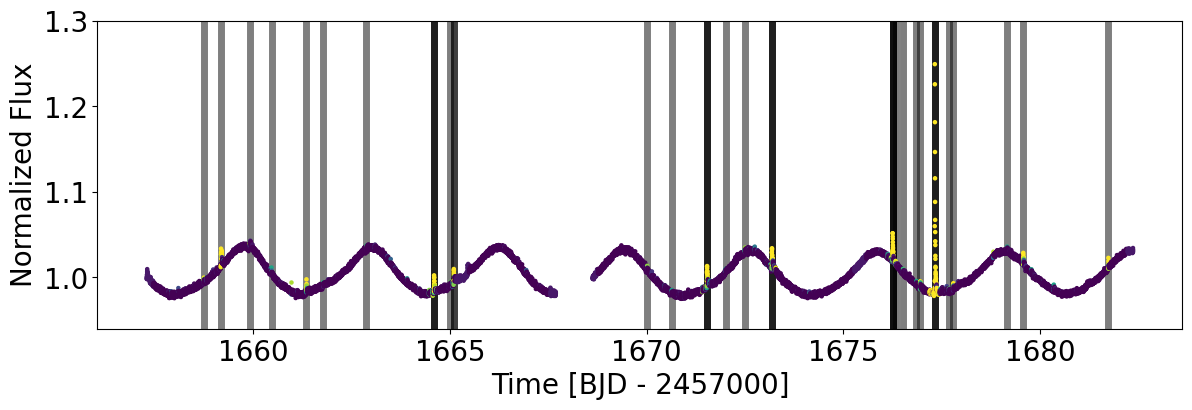

In [13]:
plt.clf()
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn.predictions[0], s=5)

for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux')
plt.show();

<Figure size 640x480 with 0 Axes>

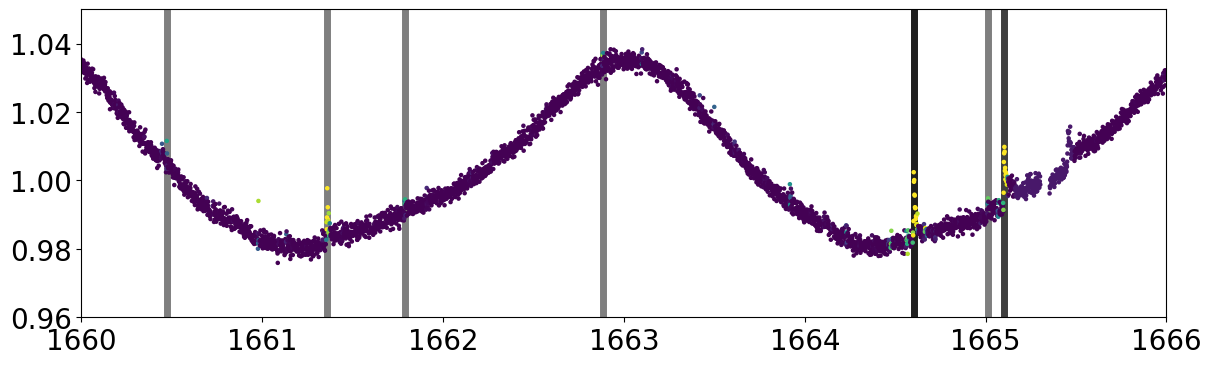

In [14]:
plt.clf()
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn.predictions[0], s=5)
for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)
plt.xlim(1660,1666)
plt.ylim(0.96,1.05)
plt.show();

You'll also note there is a flare at time$\sim$1665.5 that was not identified. As there was a significant gap in the data and the CNN cannot handle data gap, the cadences around this region were ignored. Hence, that flare was not identified. 

Additionally, the light curve looks to have a few flares at time$\sim$1663. Zooming in, these don't look like flares. This is better seen when the eye is not guided by the prediction assignment of the neural network:

<Figure size 640x480 with 0 Axes>

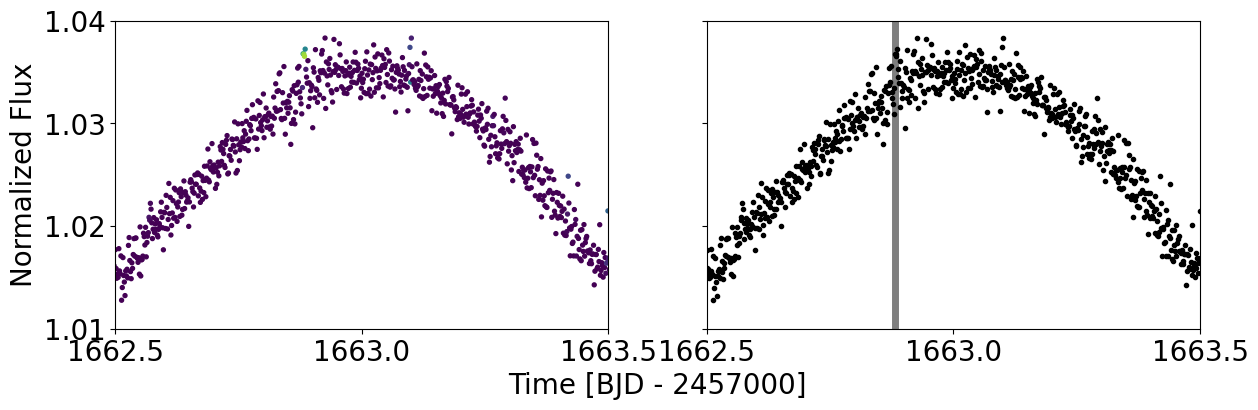

In [15]:
plt.clf()
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4), sharex=True, sharey=True)
ax1.scatter(ff.time[0], ff.flux[0], c=cnn.predictions[0], s=8)
ax2.plot(ff.time[0], ff.flux[0], 'k.')
for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)
plt.xlim(1662.5,1663.5)
plt.ylim(1.01,1.04)
plt.xticks(np.arange(1662.5, 1664.0, 0.5))
ax1.set_ylabel('Normalized Flux')
ax1.set_xlabel('Time [BJD - 2457000]', x=1.1)
plt.show();